# 04_analyze_discriminative — MCQ Results Analysis

This notebook aggregates and analyzes discriminative (MCQ) probing results saved as `results/runs/<run_id>/<model>/<task>/mcq_results.jsonl`.

It provides:
- Accuracy by model per run and for the latest run
- Confidence analysis (histograms and reliability diagrams)
- Per-question difficulty (hardest/easiest items)
- Pairwise model agreement heatmap
- Exports summary CSVs and figures to `results/analysis/<timestamp>/`



In [1]:
# Ensure project root is on sys.path and as working directory so `src/...` imports work
import os
import sys
from pathlib import Path


def find_project_root() -> Path:
    cwd = Path.cwd()
    for parent in [cwd, *cwd.parents]:
        if (parent / "src").exists() or (parent / "config").exists():
            return parent
    return cwd

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# Also set CWD so relative paths like "results/runs/..." work from notebooks
os.chdir(PROJECT_ROOT)
print(f"Using project root: {PROJECT_ROOT}")


Using project root: f:\New folder\Research\Project 1


In [18]:
# Imports and plotting defaults
import json
import re
from datetime import datetime
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Professional seaborn style defaults
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120
sns.despine()


<Figure size 1200x600 with 0 Axes>

In [19]:
# Discover and load results
from pathlib import Path
from typing import Any


def read_jsonl(path: Path) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def parse_run_meta(file_path: Path) -> Tuple[str, str, str]:
    # Expected: results/runs/<run_id>/<model>/<task>/mcq_results.jsonl
    parts = file_path.parts
    try:
        runs_idx = parts.index("runs")
        run_id = parts[runs_idx + 1]
        model = parts[runs_idx + 2]
        task = parts[runs_idx + 3]
        return run_id, model, task
    except Exception:
        return ("unknown", "unknown", "unknown")


def make_signature(stem: str, options: List[str]) -> str:
    # Deterministic signature to compare the same item across runs/models
    return f"{stem}|||{' || '.join(options)}"


def load_all_results(root: Path = Path("results/runs")) -> pd.DataFrame:
    files = list(root.glob("**/mcq_results.jsonl"))
    records: List[Dict[str, Any]] = []
    for fp in files:
        run_id, model, task = parse_run_meta(fp)
        try:
            rows = read_jsonl(fp)
        except Exception as e:
            print(f"Failed to read {fp}: {e}")
            continue
        for r in rows:
            stem = r.get("stem", "")
            options = r.get("options", [])
            record = {
                "run_id": run_id,
                "model": model,
                "task": task,
                "stem": stem,
                "options": options,
                "gold": r.get("gold"),
                "pred": r.get("pred"),
                "probs": r.get("probs", {}),
                "signature": make_signature(stem, options),
            }
            records.append(record)
    if not records:
        return pd.DataFrame(columns=["run_id","model","task","stem","options","gold","pred","probs","signature"])    
    return pd.DataFrame.from_records(records)


df = load_all_results()
print(f"Loaded {len(df)} rows from {df['run_id'].nunique()} run(s), {df['model'].nunique()} model(s), {df['task'].nunique()} task(s)")
df.head(3)


Loaded 7611 rows from 3 run(s), 3 model(s), 1 task(s)


,run_id,model,task,stem,options,gold,pred,probs,signature
0,20251113-102037,openrouter-llama,values_norms,How important is Family in your life?,"[Very important, Rather important, Not very im...",very_important,Very important,"{'Very important': 1.0, 'Rather important': 0....",How important is Family in your life?|||Very i...
1,20251113-102037,openrouter-llama,values_norms,How important are Friends in your life?,"[Very important, Rather important, Not very im...",rather_important,Very important,"{'Very important': 1.0, 'Rather important': 0....",How important are Friends in your life?|||Very...
2,20251113-102037,openrouter-llama,values_norms,How important is Leisure time in your life?,"[Very important, Rather important, Not very im...",not_very_important,Very important,"{'Very important': 1.0, 'Rather important': 0....",How important is Leisure time in your life?|||...


In [20]:
# Enrich dataframe with correctness and confidence features
from math import log


def safe_dict(d: Any) -> Dict[str, float]:
    if isinstance(d, dict):
        # Ensure floatable values
        return {str(k): float(v) for k, v in d.items() if isinstance(v, (int, float, np.number))}
    return {}


def shannon_entropy(probs: Dict[str, float]) -> float:
    if not probs:
        return np.nan
    values = np.array(list(probs.values()), dtype=float)
    if values.sum() <= 0:
        return np.nan
    p = values / values.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        terms = np.where(p > 0, -p * np.log2(p), 0.0)
    return float(np.nansum(terms))


df = df.copy()
df["is_correct"] = (df["pred"] == df["gold"]).astype(float)
df["num_options"] = df["options"].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# Normalize probability dicts and compute simple features
probs_series = df["probs"].apply(safe_dict)
df["pred_prob"] = [p.get(pred, np.nan) if isinstance(p, dict) else np.nan for p, pred in zip(probs_series, df["pred"]) ]
df["gold_prob"] = [p.get(gold, np.nan) if isinstance(p, dict) else np.nan for p, gold in zip(probs_series, df["gold"]) ]
df["max_prob"]  = [max(p.values()) if isinstance(p, dict) and len(p)>0 else np.nan for p in probs_series]
df["entropy"]   = [shannon_entropy(p) for p in probs_series]

# Parse run_id to datetime for sorting and filtering

def parse_run_dt(run_id: str) -> datetime:
    try:
        return datetime.strptime(run_id, "%Y%m%d-%H%M%S")
    except Exception:
        return pd.NaT

df["run_dt"] = df["run_id"].apply(parse_run_dt)

print("Columns:", list(df.columns))
df.sample(min(5, len(df)))


Columns: ['run_id', 'model', 'task', 'stem', 'options', 'gold', 'pred', 'probs', 'signature', 'is_correct', 'num_options', 'pred_prob', 'gold_prob', 'max_prob', 'entropy', 'run_dt']


,run_id,model,task,stem,options,gold,pred,probs,signature,is_correct,num_options,pred_prob,gold_prob,max_prob,entropy,run_dt
3411,20251112-191052,gemini,values_norms,Is 'Imagination' among the top five qualities ...,"[Mentioned, Not mentioned]",Mentioned,Mentioned,"{'Mentioned': 0.0, 'Not mentioned': 0.0}",Is 'Imagination' among the top five qualities ...,1.0,2,0.0,0.0,0.0,NaN,2025-11-12 19:10:52
4157,20251112-191052,gemini,values_norms,Would you not like to have Heavy drinkers as n...,"[Would not like as neighbours, Would like as n...",Would not like as neighbours,Would not like as neighbours,"{'Would not like as neighbours': 0.0, 'Would l...",Would you not like to have Heavy drinkers as n...,1.0,2,0.0,0.0,0.0,NaN,2025-11-12 19:10:52
5070,20251112-191052,gemini,values_norms,Would you not like to have People of a differe...,"[Would not like as neighbours, Would like as n...",Would like as neighbours,Would not like as neighbours,"{'Would not like as neighbours': 0.0, 'Would l...",Would you not like to have People of a differe...,0.0,2,0.0,0.0,0.0,NaN,2025-11-12 19:10:52
2729,20251112-191052,gemini,values_norms,"Is 'Thrift, saving money and things' among the...","[Mentioned, Not mentioned]",Not mentioned,Mentioned,"{'Mentioned': 0.0, 'Not mentioned': 0.0}","Is 'Thrift, saving money and things' among the...",0.0,2,0.0,0.0,0.0,NaN,2025-11-12 19:10:52
6440,20251112-190119,openrouter-kimi,values_norms,Would you not like to have People who speak a ...,"[Would not like as neighbours, Would like as n...",Would like as neighbours,Would not like as neighbours,"{'Would not like as neighbours': 1.0, 'Would l...",Would you not like to have People who speak a ...,0.0,2,1.0,0.0,1.0,0.0,2025-11-12 19:01:19


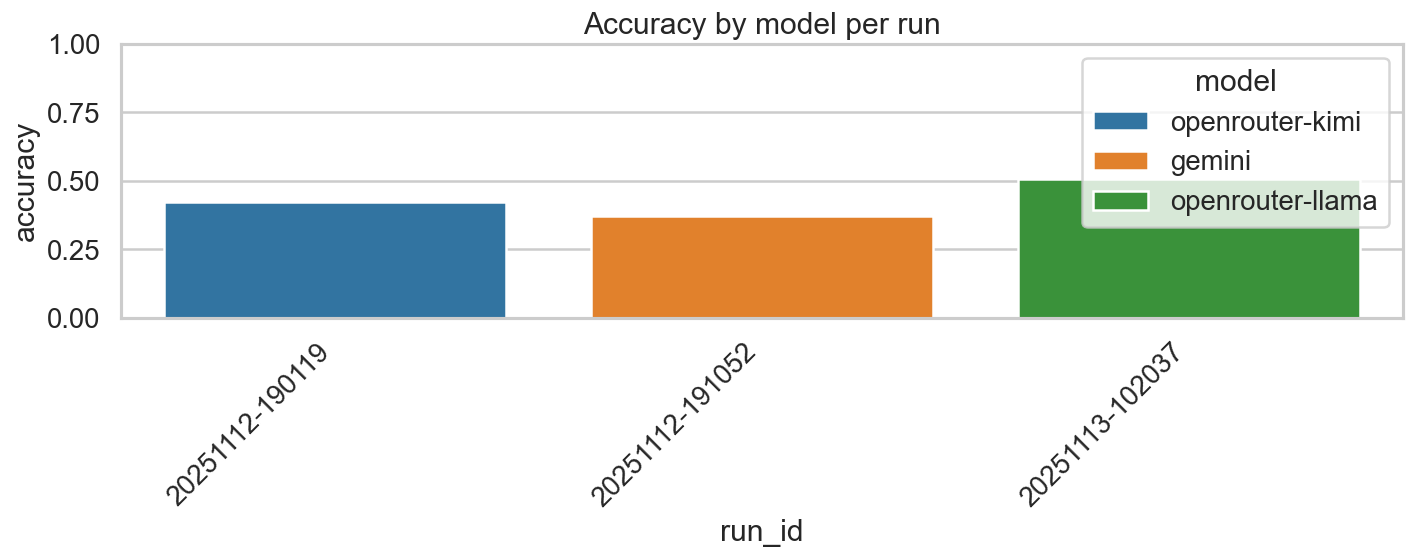

'\nif df["run_dt"].notna().any():\n    latest_dt = df["run_dt"].max()\n    latest_run_id = df.loc[df["run_dt"] == latest_dt, "run_id"].iloc[0]\nelse:\n    latest_run_id = df["run_id"].iloc[-1] if len(df) > 0 else None\n\nprint("Latest run:", latest_run_id)\n\nif latest_run_id is not None:\n    df_latest = df[df["run_id"] == latest_run_id]\n    acc_latest = (\n        df_latest.groupby(["model"], dropna=False)["is_correct"].mean().reset_index()\n        .rename(columns={"is_correct": "accuracy"})\n    )\n    display(acc_latest.sort_values("accuracy", ascending=False))\n\n    plt.figure(figsize=(7, 4))\n    sns.barplot(data=acc_latest, x="model", y="accuracy", palette="tab10")\n    plt.title(f"Accuracy by model — latest run {latest_run_id}")\n    plt.ylim(0, 1)\n    plt.xlabel("model")\n    plt.ylabel("accuracy")\n    plt.tight_layout()\n    plt.show()\n'

In [22]:
# Accuracy by model per run and latest run

# Overall accuracy grouped by run_id and model
acc_by_run_model = (
    df.groupby(["run_id", "model"], dropna=False)["is_correct"].mean().reset_index()
    .rename(columns={"is_correct": "accuracy"})
)

# Display table
acc_by_run_model.sort_values(["run_id", "model"], inplace=True)
acc_by_run_model

# Plot accuracy by model per run
plt.figure(figsize=(12, 5))
sns.barplot(
    data=acc_by_run_model,
    x="run_id",
    y="accuracy",
    hue="model",
    palette="tab10",
)
plt.title("Accuracy by model per run")
plt.ylim(0, 1)
plt.xlabel("run_id")
plt.ylabel("accuracy")
plt.legend(title="model")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Latest run only
"""
if df["run_dt"].notna().any():
    latest_dt = df["run_dt"].max()
    latest_run_id = df.loc[df["run_dt"] == latest_dt, "run_id"].iloc[0]
else:
    latest_run_id = df["run_id"].iloc[-1] if len(df) > 0 else None

print("Latest run:", latest_run_id)

if latest_run_id is not None:
    df_latest = df[df["run_id"] == latest_run_id]
    acc_latest = (
        df_latest.groupby(["model"], dropna=False)["is_correct"].mean().reset_index()
        .rename(columns={"is_correct": "accuracy"})
    )
    display(acc_latest.sort_values("accuracy", ascending=False))

    plt.figure(figsize=(7, 4))
    sns.barplot(data=acc_latest, x="model", y="accuracy", palette="tab10")
    plt.title(f"Accuracy by model — latest run {latest_run_id}")
    plt.ylim(0, 1)
    plt.xlabel("model")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()
"""

In [23]:
# Confidence analysis: histograms and reliability diagrams (latest run)

def plot_confidence_histograms(df_latest: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        data=df_latest,
        x="max_prob",
        hue="model",
        element="step",
        stat="density",
        common_norm=False,
        bins=20,
    )
    plt.title("Distribution of max_prob (latest run)")
    plt.xlabel("max_prob (top option probability)")
    plt.ylabel("density")
    plt.tight_layout()
    plt.show()


def reliability_data(df_m: pd.DataFrame, n_bins: int = 10) -> pd.DataFrame:
    # Use max_prob as confidence; compute empirical accuracy per bin
    d = df_m[["max_prob", "is_correct"]].dropna()
    if d.empty:
        return pd.DataFrame(columns=["bin_start","bin_end","confidence","accuracy","count"])
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    d = d.copy()
    d["bin"] = pd.cut(d["max_prob"], bins=bins, include_lowest=True, right=True)
    grouped = d.groupby("bin", observed=True)
    out = grouped.agg(confidence=("max_prob", "mean"), accuracy=("is_correct", "mean"), count=("is_correct", "size")).reset_index()
    # Extract bin edges for plotting
    out["bin_start"] = out["bin"].apply(lambda x: x.left if pd.notna(x) else np.nan)
    out["bin_end"] = out["bin"].apply(lambda x: x.right if pd.notna(x) else np.nan)
    return out


def plot_reliability_by_model(df_latest: pd.DataFrame, n_bins: int = 10) -> None:
    plt.figure(figsize=(6, 6))
    for model, d in df_latest.groupby("model"):
        rd = reliability_data(d, n_bins=n_bins)
        if rd.empty:
            continue
        plt.plot(rd["confidence"], rd["accuracy"], marker="o", label=model)
    # Perfect calibration line
    xs = np.linspace(0, 1, 50)
    plt.plot(xs, xs, "k--", alpha=0.5, label="perfect")
    plt.title("Reliability diagram (latest run)")
    plt.xlabel("confidence (mean max_prob)")
    plt.ylabel("empirical accuracy")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

#if latest_run_id is not None:
#    plot_confidence_histograms(df_latest)
#    plot_reliability_by_model(df_latest, n_bins=10)


Hardest items (lowest mean accuracy across models):


,stem_short,mean_accuracy
0,How important are Friends in your life?,0.000000
1,How important is Family in your life?,0.000000
2,How important is Leisure time in your life?,0.000000
3,How important is Politics in your life?,0.000000
4,How important is Religion in your life?,0.000000
5,How important is Work in your life?,0.000000
6,"Is 'Determination, perseverance' among the top...",0.290000
19,Would you not like to have Homosexuals as neig...,0.308642
25,Would you not like to have Unmarried couples l...,0.365591
23,Would you not like to have People who have AID...,0.377778


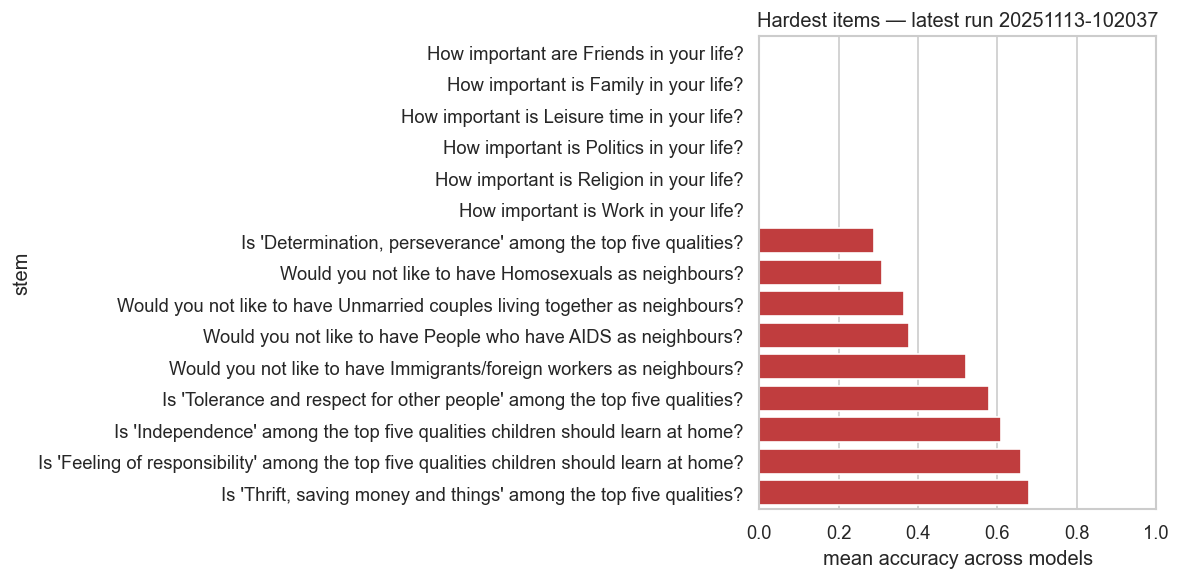

Easiest items (highest mean accuracy across models):


,stem_short,mean_accuracy
17,Would you not like to have Drug addicts as nei...,0.900000
18,Would you not like to have Heavy drinkers as n...,0.857143
8,Is 'Good manners' among the top five qualities...,0.820000
24,Would you not like to have People who speak a ...,0.816327
12,Is 'Not being selfish (unselfishness)' among t...,0.790000
9,Is 'Hard work' among the top five qualities ch...,0.780000
21,Would you not like to have People of a differe...,0.767677
22,Would you not like to have People of a differe...,0.752577
10,Is 'Imagination' among the top five qualities ...,0.750000
13,Is 'Obedience' among the top five qualities?,0.750000


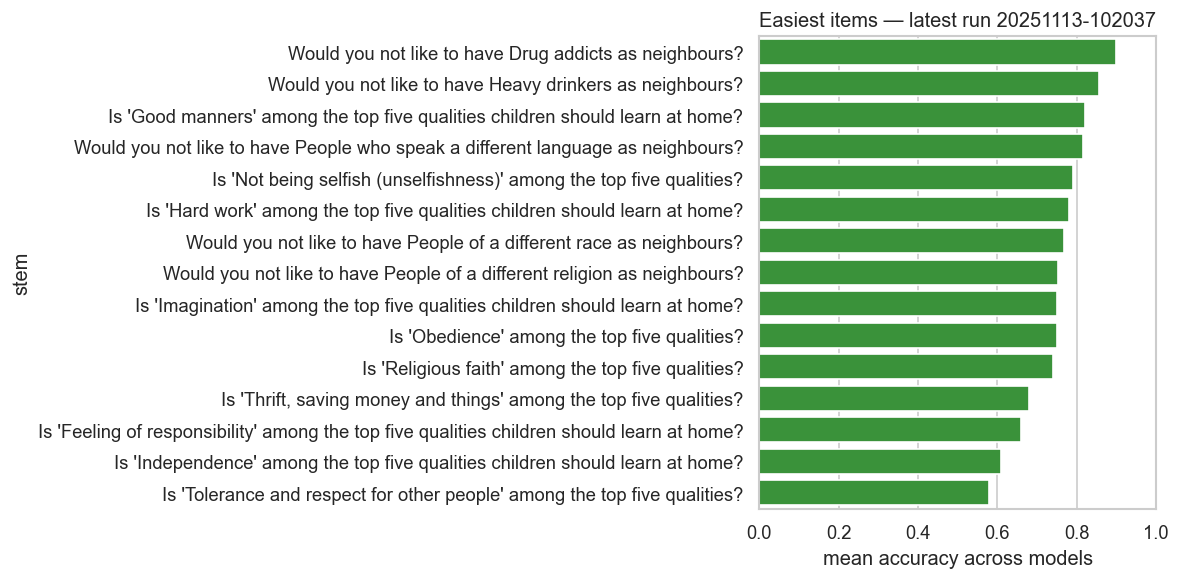

In [7]:
# Per-question difficulty (latest run): hardest and easiest items

def truncate(text: str, max_len: int = 120) -> str:
    if len(text) <= max_len:
        return text
    return text[: max_len - 1] + "…"

if latest_run_id is not None:
    # Difficulty per item signature averaged across models
    item_stats = (
        df_latest.groupby(["signature", "stem"], dropna=False)["is_correct"].mean().reset_index()
        .rename(columns={"is_correct": "mean_accuracy"})
    )
    hardest = item_stats.sort_values("mean_accuracy", ascending=True).head(15).copy()
    easiest = item_stats.sort_values("mean_accuracy", ascending=False).head(15).copy()
    hardest["stem_short"] = hardest["stem"].astype(str).apply(lambda s: truncate(s, 120))
    easiest["stem_short"] = easiest["stem"].astype(str).apply(lambda s: truncate(s, 120))

    print("Hardest items (lowest mean accuracy across models):")
    display(hardest[["stem_short", "mean_accuracy"]])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=hardest, x="mean_accuracy", y="stem_short", color="#d62728")
    plt.title(f"Hardest items — latest run {latest_run_id}")
    plt.xlabel("mean accuracy across models")
    plt.ylabel("stem")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

    print("Easiest items (highest mean accuracy across models):")
    display(easiest[["stem_short", "mean_accuracy"]])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=easiest, x="mean_accuracy", y="stem_short", color="#2ca02c")
    plt.title(f"Easiest items — latest run {latest_run_id}")
    plt.xlabel("mean accuracy across models")
    plt.ylabel("stem")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


,openrouter-llama
openrouter-llama,NaN


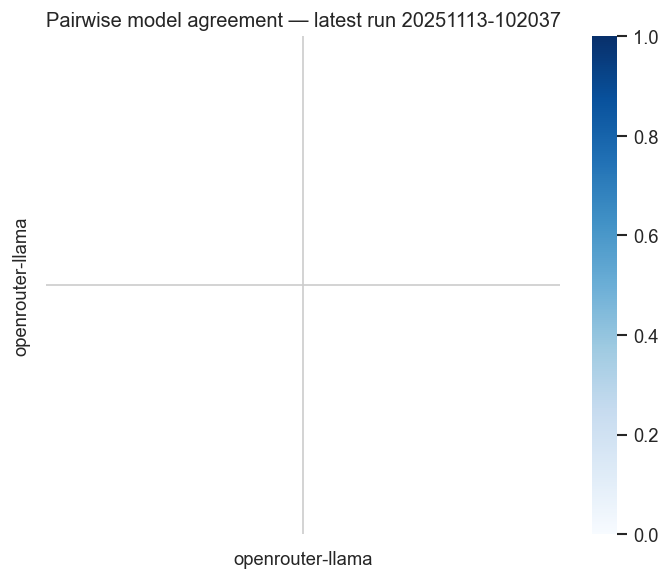

In [10]:
# Pairwise model agreement (latest run)
import itertools


def pairwise_agreement_matrix(df_latest: pd.DataFrame) -> pd.DataFrame:
    # Build wide table: one row per item signature, columns are model predictions
    pivot = (
        df_latest.pivot_table(index="signature", columns="model", values="pred", aggfunc=lambda x: x.iloc[0])
    )
    models = list(pivot.columns)
    if len(models) < 2:
        return pd.DataFrame(index=models, columns=models, dtype=float)
    
    agreement = pd.DataFrame(index=models, columns=models, dtype=float)
    for m1, m2 in itertools.product(models, models):
        s1 = pivot[m1]
        s2 = pivot[m2]
        mask = s1.notna() & s2.notna()
        if mask.sum() == 0:
            agreement.loc[m1, m2] = np.nan
        else:
            agreement.loc[m1, m2] = float((s1[mask] == s2[mask]).mean())  # Explicit float conversion
    return agreement

if latest_run_id is not None:
    agree = pairwise_agreement_matrix(df_latest)
    
    # Convert to float explicitly to ensure correct dtype
    agree = agree.astype(float)
    
    display(agree)
    plt.figure(figsize=(6, 5))
    sns.heatmap(agree, vmin=0, vmax=1, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f"Pairwise model agreement — latest run {latest_run_id}")
    plt.tight_layout()
    plt.show()

## Enhanced insights and professional seaborn visuals

We extend the analysis with:
- Category-wise accuracy (Importance, Child qualities, Neighbours)
- Impact of label formatting issues (gold-in-options match)
- Calibration metrics per model (ECE, Brier score)
- Confidence/uncertainty relationship (entropy vs accuracy)
- Agreement dynamics: when models agree, are they right?



In [12]:
# Feature engineering and additional summary tables (latest run)
import numpy as np
import pandas as pd
import re

# Categorize stems for higher-level insights
def categorize_stem(text: str) -> str:
    s = str(text or "")
    sl = s.lower()
    if sl.startswith("how important"):
        return "Importance"
    if s.startswith("Is '") or s.startswith('Is "'):
        return "Child qualities"
    if s.startswith("Would you not like to have"):
        return "Neighbours"
    return "Other"

# Compute categories and whether gold label matches any option text (format sanity)
df = df.copy()
df["category"] = df["stem"].apply(categorize_stem)

def gold_in_options_row(row) -> bool:
    opts = row["options"] if isinstance(row["options"], list) else []
    return row["gold"] in opts

df["gold_in_options"] = df.apply(gold_in_options_row, axis=1)

# Latest run filtered
if latest_run_id is not None:
    df_latest = df[df["run_id"] == latest_run_id].copy()

    # Category-wise accuracy per model
    acc_category = (
        df_latest.groupby(["model", "category"], dropna=False)["is_correct"].mean().reset_index()
        .rename(columns={"is_correct": "accuracy"})
    )

    # Effect of gold label formatting (does gold appear verbatim in options?)
    gold_in_options_acc = (
        df_latest.groupby(["model", "gold_in_options"], dropna=False)["is_correct"].mean().reset_index()
        .rename(columns={"is_correct": "accuracy"})
    )

    # Calibration metrics: Expected Calibration Error (ECE) and Brier score
    def expected_calibration_error(d: pd.DataFrame, n_bins: int = 10) -> float:
        sub = d[["max_prob", "is_correct"]].dropna()
        if sub.empty:
            return float("nan")
        bins = np.linspace(0.0, 1.0, n_bins + 1)
        sub = sub.copy()
        sub["bin"] = pd.cut(sub["max_prob"], bins=bins, include_lowest=True, right=True)
        total = len(sub)
        ece_val = 0.0
        for _, g in sub.groupby("bin", observed=True):
            if len(g) == 0:
                continue
            conf = float(g["max_prob"].mean())
            acc = float(g["is_correct"].mean())
            ece_val += (len(g) / total) * abs(acc - conf)
        return float(ece_val)

    def brier_score(d: pd.DataFrame) -> float:
        # Use max_prob as confidence for correctness-as-binary target
        sub = d[["max_prob", "is_correct"]].dropna()
        if sub.empty:
            return float("nan")
        y = sub["is_correct"].astype(float).to_numpy()
        p = sub["max_prob"].astype(float).to_numpy()
        return float(np.mean((p - y) ** 2))

    calib_rows = []
    for model, d in df_latest.groupby("model"):
        calib_rows.append({
            "model": model,
            "ece": expected_calibration_error(d, n_bins=10),
            "brier": brier_score(d),
        })
    calib_df = pd.DataFrame.from_records(calib_rows)

    # Entropy vs accuracy (binned curve per model)
    def entropy_accuracy_curve(d: pd.DataFrame, n_bins: int = 12) -> pd.DataFrame:
        sub = d[["entropy", "is_correct"]].dropna()
        if sub.empty:
            return pd.DataFrame(columns=["entropy_center", "accuracy"])  # empty
        emax = float(sub["entropy"].max())
        if not np.isfinite(emax) or emax <= 0:
            return pd.DataFrame(columns=["entropy_center", "accuracy"])  # empty
        bins = np.linspace(0.0, emax, n_bins + 1)
        sub = sub.copy()
        sub["bin"] = pd.cut(sub["entropy"], bins=bins, include_lowest=True, right=True)
        out = sub.groupby("bin", observed=True).agg(
            entropy_center=("entropy", "mean"),
            accuracy=("is_correct", "mean"),
            count=("is_correct", "size"),
        ).reset_index(drop=True)
        return out

    ent_curves = []
    for model, d in df_latest.groupby("model"):
        c = entropy_accuracy_curve(d, n_bins=12)
        if not c.empty:
            c["model"] = model
            ent_curves.append(c)
    entropy_curve_df = pd.concat(ent_curves, ignore_index=True) if ent_curves else pd.DataFrame()



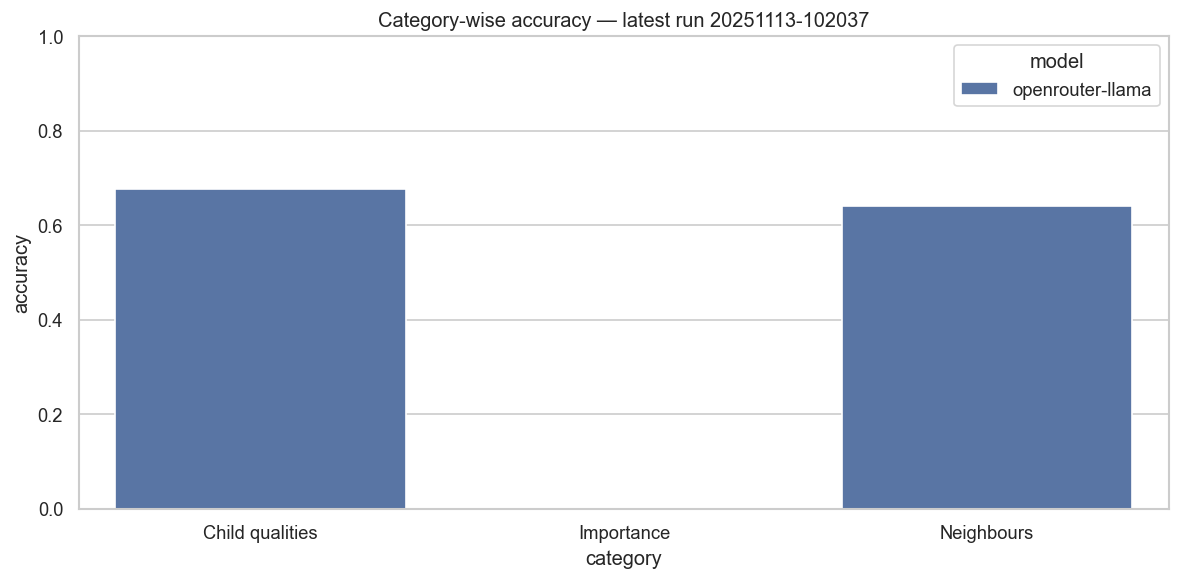

In [13]:
# Plot: Category-wise accuracy by model (latest run)
if latest_run_id is not None and 'acc_category' in locals() and not acc_category.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=acc_category, x="category", y="accuracy", hue="model")
    plt.title(f"Category-wise accuracy — latest run {latest_run_id}")
    plt.ylim(0, 1)
    plt.xlabel("category")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()



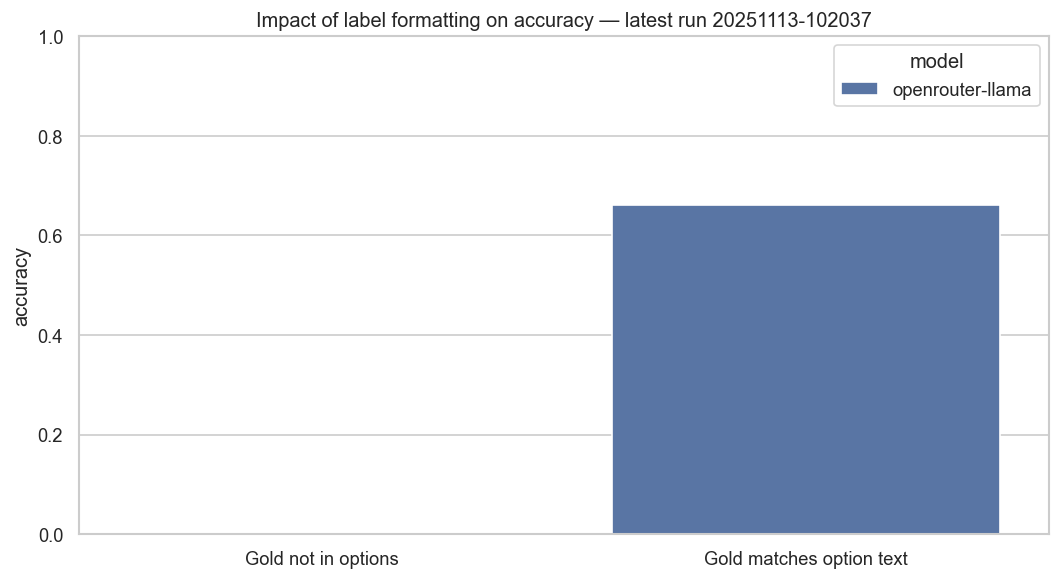

In [14]:
# Plot: Effect of gold-in-options match on accuracy (latest run)
if latest_run_id is not None and 'gold_in_options_acc' in locals() and not gold_in_options_acc.empty:
    acc_tmp = gold_in_options_acc.copy()
    acc_tmp["gold_in_options"] = acc_tmp["gold_in_options"].map({True: "Gold matches option text", False: "Gold not in options"})

    plt.figure(figsize=(9, 5))
    sns.barplot(data=acc_tmp, x="gold_in_options", y="accuracy", hue="model")
    plt.title(f"Impact of label formatting on accuracy — latest run {latest_run_id}")
    plt.ylim(0, 1)
    plt.xlabel("")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()



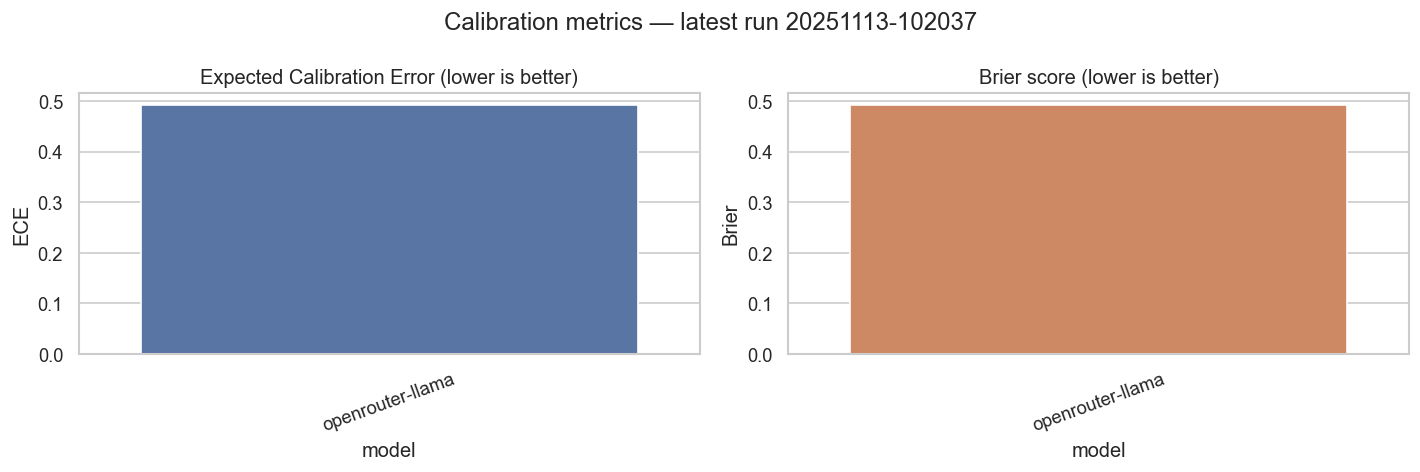

In [15]:
# Plot: Calibration metrics (ECE and Brier score) per model (latest run)
if latest_run_id is not None and 'calib_df' in locals() and not calib_df.empty:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    # ECE (lower is better)
    sns.barplot(data=calib_df, x="model", y="ece", color=sns.color_palette()[0], ax=axes[0])
    axes[0].set_title("Expected Calibration Error (lower is better)")
    axes[0].set_xlabel("model")
    axes[0].set_ylabel("ECE")
    axes[0].tick_params(axis='x', rotation=20)

    # Brier score (lower is better)
    sns.barplot(data=calib_df, x="model", y="brier", color=sns.color_palette()[1], ax=axes[1])
    axes[1].set_title("Brier score (lower is better)")
    axes[1].set_xlabel("model")
    axes[1].set_ylabel("Brier")
    axes[1].tick_params(axis='x', rotation=20)

    fig.suptitle(f"Calibration metrics — latest run {latest_run_id}")
    fig.tight_layout()
    plt.show()



In [16]:
# Plot: Entropy vs empirical accuracy (binned) per model (latest run)
if latest_run_id is not None and 'entropy_curve_df' in locals() and not entropy_curve_df.empty:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=entropy_curve_df, x="entropy_center", y="accuracy", hue="model", marker="o")
    plt.title(f"Uncertainty (entropy) vs accuracy — latest run {latest_run_id}")
    plt.xlabel("entropy (Shannon)")
    plt.ylabel("accuracy (binned)")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()



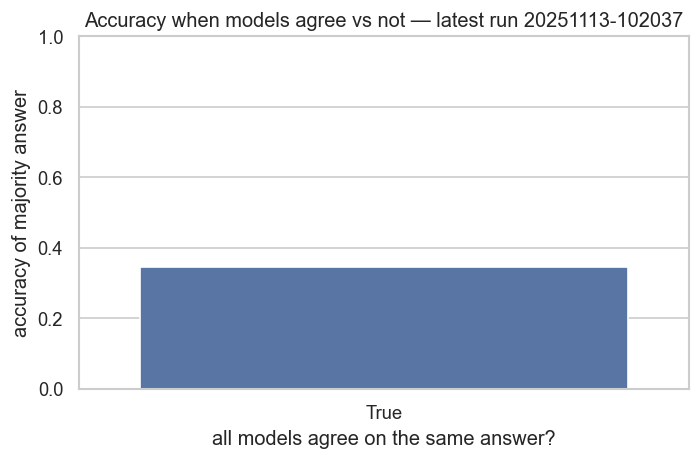

In [17]:
# Agreement analysis: when models agree, are they correct? (latest run)
import numpy as np
import pandas as pd

if latest_run_id is not None:
    # Wide pivot of predictions by model per item signature
    pivot_preds = df_latest.pivot_table(index="signature", columns="model", values="pred", aggfunc=lambda x: x.iloc[0])
    gold_by_sig = df_latest.groupby("signature", dropna=False)["gold"].agg(lambda s: s.iloc[0])

    # Compute agreement and majority correctness per item
    def compute_row_stats(row: pd.Series) -> pd.Series:
        vals = row.dropna().tolist()
        n = len(vals)
        if n == 0:
            return pd.Series({"all_agree": np.nan, "majority_pred": np.nan, "n_models": 0})
        vc = pd.Series(vals).value_counts()
        majority_pred = vc.index[0]
        all_agree = (len(vc) == 1)
        return pd.Series({"all_agree": all_agree, "majority_pred": majority_pred, "n_models": n})

    row_stats = pivot_preds.apply(compute_row_stats, axis=1)
    agree_df = row_stats.join(gold_by_sig.rename("gold"))
    agree_df["majority_correct"] = (agree_df["majority_pred"] == agree_df["gold"]).astype(float)

    # Summary: accuracy conditional on all_agree
    agree_summary = (
        agree_df.groupby("all_agree", dropna=False)["majority_correct"].mean().reset_index()
        .rename(columns={"majority_correct": "accuracy"})
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(data=agree_summary, x="all_agree", y="accuracy", color=sns.color_palette()[0])
    plt.title(f"Accuracy when models agree vs not — latest run {latest_run_id}")
    plt.ylim(0, 1)
    plt.xlabel("all models agree on the same answer?")
    plt.ylabel("accuracy of majority answer")
    plt.tight_layout()
    plt.show()



In [ ]:
# Additional exports for new insights
from datetime import timezone
from pathlib import Path

# Reuse or create analysis directory
if 'analysis_dir' not in locals():
    analysis_id_extra = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%S")
    analysis_dir = Path("results/analysis") / analysis_id_extra
    analysis_dir.mkdir(parents=True, exist_ok=True)
    print("Saving additional analysis to:", analysis_dir)

if latest_run_id is not None:
    # Save tables
    if 'acc_category' in locals() and not acc_category.empty:
        acc_category.to_csv(analysis_dir / f"category_accuracy_{latest_run_id}.csv", index=False)
    if 'gold_in_options_acc' in locals() and not gold_in_options_acc.empty:
        gold_in_options_acc.to_csv(analysis_dir / f"gold_in_options_accuracy_{latest_run_id}.csv", index=False)
    if 'calib_df' in locals() and not calib_df.empty:
        calib_df.to_csv(analysis_dir / f"calibration_metrics_{latest_run_id}.csv", index=False)
    if 'agree_summary' in locals() and not agree_summary.empty:
        agree_summary.to_csv(analysis_dir / f"agreement_accuracy_{latest_run_id}.csv", index=False)

    # Save figures (replot minimally to files)
    if 'acc_category' in locals() and not acc_category.empty:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.barplot(data=acc_category, x="category", y="accuracy", hue="model", ax=ax)
        ax.set_title(f"Category-wise accuracy — latest run {latest_run_id}")
        ax.set_ylim(0, 1)
        ax.set_xlabel("category")
        ax.set_ylabel("accuracy")
        fig.tight_layout()
        fig.savefig(analysis_dir / f"category_accuracy_{latest_run_id}.png", dpi=160)
        plt.close(fig)

    if 'gold_in_options_acc' in locals() and not gold_in_options_acc.empty:
        tmp = gold_in_options_acc.copy()
        tmp["gold_in_options"] = tmp["gold_in_options"].map({True: "Gold matches option text", False: "Gold not in options"})
        fig, ax = plt.subplots(figsize=(9, 5))
        sns.barplot(data=tmp, x="gold_in_options", y="accuracy", hue="model", ax=ax)
        ax.set_title(f"Label formatting impact — latest run {latest_run_id}")
        ax.set_ylim(0, 1)
        ax.set_xlabel("")
        ax.set_ylabel("accuracy")
        fig.tight_layout()
        fig.savefig(analysis_dir / f"gold_in_options_accuracy_{latest_run_id}.png", dpi=160)
        plt.close(fig)

    if 'calib_df' in locals() and not calib_df.empty:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
        sns.barplot(data=calib_df, x="model", y="ece", color=sns.color_palette()[0], ax=axes[0])
        axes[0].set_title("Expected Calibration Error")
        axes[0].set_xlabel("model")
        axes[0].set_ylabel("ECE")
        axes[0].tick_params(axis='x', rotation=20)
        sns.barplot(data=calib_df, x="model", y="brier", color=sns.color_palette()[1], ax=axes[1])
        axes[1].set_title("Brier score")
        axes[1].set_xlabel("model")
        axes[1].set_ylabel("Brier")
        axes[1].tick_params(axis='x', rotation=20)
        fig.suptitle(f"Calibration metrics — latest run {latest_run_id}")
        fig.tight_layout()
        fig.savefig(analysis_dir / f"calibration_{latest_run_id}.png", dpi=160)
        plt.close(fig)

    if 'entropy_curve_df' in locals() and not entropy_curve_df.empty:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(data=entropy_curve_df, x="entropy_center", y="accuracy", hue="model", marker="o", ax=ax)
        ax.set_title(f"Entropy vs accuracy — latest run {latest_run_id}")
        ax.set_xlabel("entropy (Shannon)")
        ax.set_ylabel("accuracy (binned)")
        ax.set_ylim(0, 1)
        fig.tight_layout()
        fig.savefig(analysis_dir / f"entropy_accuracy_{latest_run_id}.png", dpi=160)
        plt.close(fig)

    if 'agree_summary' in locals() and not agree_summary.empty:
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.barplot(data=agree_summary, x="all_agree", y="accuracy", color=sns.color_palette()[0], ax=ax)
        ax.set_title(f"Agreement vs accuracy — latest run {latest_run_id}")
        ax.set_ylim(0, 1)
        ax.set_xlabel("all models agree?")
        ax.set_ylabel("accuracy of majority answer")
        fig.tight_layout()
        fig.savefig(analysis_dir / f"agreement_accuracy_{latest_run_id}.png", dpi=160)
        plt.close(fig)



In [11]:
# Save summaries and figures
from datetime import timezone

analysis_id = datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%S")
analysis_dir = Path("results/analysis") / analysis_id
analysis_dir.mkdir(parents=True, exist_ok=True)
print("Saving analysis to:", analysis_dir)

# Save accuracy tables
acc_by_run_model.to_csv(analysis_dir / "accuracy_by_run_model.csv", index=False)
if latest_run_id is not None:
    acc_latest.to_csv(analysis_dir / f"accuracy_latest_{latest_run_id}.csv", index=False)

# Save hardest/easiest tables
if latest_run_id is not None:
    hardest.to_csv(analysis_dir / f"hardest_items_{latest_run_id}.csv", index=False)
    easiest.to_csv(analysis_dir / f"easiest_items_{latest_run_id}.csv", index=False)

# Save agreement matrix
if latest_run_id is not None and 'agree' in globals():
    # Ensure agree is float type before saving and plotting
    agree = agree.astype(float)
    agree.to_csv(analysis_dir / f"pairwise_agreement_{latest_run_id}.csv")

# Optionally save figures by re-plotting to file
# Accuracy latest
if latest_run_id is not None:
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.barplot(data=acc_latest, x="model", y="accuracy", palette="tab10", ax=ax)
    ax.set_title(f"Accuracy by model — latest run {latest_run_id}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("model")
    ax.set_ylabel("accuracy")
    fig.tight_layout()
    fig.savefig(analysis_dir / f"accuracy_latest_{latest_run_id}.png", dpi=160)
    plt.close(fig)

    # Reliability
    fig = plt.figure(figsize=(6, 6))
    for model, d in df_latest.groupby("model"):
        rd = reliability_data(d, n_bins=10)
        if rd.empty:
            continue
        plt.plot(rd["confidence"], rd["accuracy"], marker="o", label=model)
    xs = np.linspace(0, 1, 50)
    plt.plot(xs, xs, "k--", alpha=0.5, label="perfect")
    plt.title("Reliability diagram (latest run)")
    plt.xlabel("confidence (mean max_prob)")
    plt.ylabel("empirical accuracy")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    fig.savefig(analysis_dir / f"reliability_{latest_run_id}.png", dpi=160)
    plt.close(fig)

    # Agreement heatmap
    if 'agree' in globals():
        fig, ax = plt.subplots(figsize=(6, 5))
        # Ensure agree is float type (in case it wasn't converted earlier)
        agree_plot = agree.astype(float)
        sns.heatmap(agree_plot, vmin=0, vmax=1, annot=True, cmap="Blues", fmt=".2f", ax=ax)
        ax.set_title(f"Pairwise model agreement — latest run {latest_run_id}")
        fig.tight_layout()
        fig.savefig(analysis_dir / f"agreement_{latest_run_id}.png", dpi=160)
        plt.close(fig)

print("Done.")

Saving analysis to: results\analysis\20251113-104046


C:\Users\HP\AppData\Local\Temp\ipykernel_14596\51994811.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_latest, x="model", y="accuracy", palette="tab10", ax=ax)


Done.
